https://github.com/Waikato/moa/blob/f5cdc1051a7247bb61702131aec3e62b40aa82f8/moa/src/main/java/moa/classifiers/trees/ARFHoeffdingTree.java

https://github.com/scikit-multiflow/scikit-multiflow/blob/17327dc81b7d6e35d533795ae13493ad08118708/skmultiflow/classification/trees/hoeffding_tree.py

# Classifier

In [2]:
__author__ = 'Anderson Carlos Ferreira da Silva'

import sys
import logging
from operator import attrgetter
from skmultiflow.core.utils.utils import *
from skmultiflow.classification.base import BaseClassifier
from skmultiflow.classification.trees.hoeffding_tree import HoeffdingTree
from random import randint

class ADFHoeffdingTree(HoeffdingTree):
            
    class RandomLearningNode(HoeffdingTree.ActiveLearningNode):                    
        """Random learning node.
        Parameters
        ----------
        initial_class_observations: dict (class_value, weight) or None
            Initial class observations
        """
        def __init__(self, initial_class_observations, nb_attributes):
            super().__init__(initial_class_observations)
            self.nb_attributes = nb_attributes;
            self.list_attributes = None
            
        def learn_from_instance(self, X, y, weight, ht):
            """Update the node with the provided instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes for updating the node.
            y: int
                Instance class.
            weight: float
                Instance weight.
            ht: HoeffdingTree
                Hoeffding Tree to update.
            """            
            self._observed_class_distribution[y] += weight                            
            if not self.list_attributes:
                self.list_attributes = [None] * self.nb_attributes
                for j in range(self.nb_attributes):    
                    is_unique = False
                    while is_unique == False:
                        self.list_attributes[j] = randint(0, self.nb_attributes - 1)
                        is_unique = True
                        for i in range(j):
                            if self.list_attributes[j] == self.list_attributes[i]:
                                is_unique = False
                                break
            
            for j in range(len(self.nb_attributes)):
                i = self.list_attributes[j]
                obs = self._attribute_observers[i]
                if obs is None:
                    if i in ht.nominal_attributes:
                        obs = NominalAttributeClassObserver()
                    else:
                        obs = GaussianNumericAttributeClassObserver()
                    self._attribute_observers[i] = obs
            obs.observe_attribute_class(X[i], int(y), weight)
            
    class LearningNodeNB(RandomLearningNode):

        def __init__(self, initial_class_observations, nb_attributes):
            super().__init__(initial_class_observations, nb_attributes)            
            
        def get_class_votes(self, X, ht):
            """Get the votes per class for a given instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes.
            ht: HoeffdingTree
                Hoeffding Tree.
            Returns
            -------
            dict (class_value, weight)
                Class votes for the given instance.
            """
            if self.get_weight_seen() >= ht.nb_threshold:
                return do_naive_bayes_prediction(X, self._observed_class_distribution, self._attribute_observers)
            else:
                return super().get_class_votes(X, ht)

    class LearningNodeNBAdaptive(LearningNodeNB):
        """Learning node that uses Adaptive Naive Bayes models.
        Parameters
        ----------
        initial_class_observations: dict (class_value, weight) or None
            Initial class observations
        """
        def __init__(self, initial_class_observations, nb_attributes):
            """LearningNodeNBAdaptive class constructor. """
            super().__init__(initial_class_observations, nb_attributes)
            self._mc_correct_weight = 0.0
            self._nb_correct_weight = 0.0

        def learn_from_instance(self, X, y, weight, ht):
            """Update the node with the provided instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes for updating the node.
            y: int
                Instance class.
            weight: float
                The instance's weight.
            ht: HoeffdingTree
                The Hoeffding Tree to update.
            """
            if self._observed_class_distribution == {}:
                # All classes equal, default to class 0
                if 0 == y:
                    self._mc_correct_weight += weight
            if max(self._observed_class_distribution, key=self._observed_class_distribution.get) == y:
                self._mc_correct_weight += weight
            nb_prediction = do_naive_bayes_prediction(X, self._observed_class_distribution, self._attribute_observers)
            if max(nb_prediction, key=nb_prediction.get) == y:
                self._nb_correct_weight += weight
            super().learn_from_instance(X, y, weight, ht)

        def get_class_votes(self, X, ht):
            """Get the votes per class for a given instance.
            Parameters
            ----------
            X: numpy.ndarray of length equal to the number of features.
                Instance attributes.
            ht: HoeffdingTree
                Hoeffding Tree.
            Returns
            -------
            dict (class_value, weight)
                Class votes for the given instance.
            """
            if self._mc_correct_weight > self._nb_correct_weight:
                return self._observed_class_distribution
            return do_naive_bayes_prediction(X, self._observed_class_distribution, self._attribute_observers)
        
    def __init__(self, max_byte_size = 33554432, memory_estimate_period = 1000000, grace_period = 200,
                     split_criterion = 'info_gain', split_confidence = 0.0000001, tie_threshold = 0.05, 
                     binary_split = False, stop_mem_management = False, remove_poor_atts = False, no_preprune = False, 
                     leaf_prediction='mc', nb_threshold = 0, nominal_attributes = None, nb_attributes = 2):                
        """ADFHoeffdingTree class constructor."""
        super().__init__(max_byte_size, memory_estimate_period, grace_period, split_criterion, split_confidence,
                        tie_threshold, binary_split, stop_mem_management, remove_poor_atts, no_preprune,
                        leaf_prediction, nb_threshold, nominal_attributes)
        self.nb_attributes = nb_attributes
        self.remove_poor_attributes_option = None        

    def newLearningNode(self, initial_class_observations):        
        if self._leaf_prediction == MAJORITY_CLASS:
            return RandomLearningNode(self, initialClassObservations, self.nb_attributes)            
        elif self._leaf_prediction == NAIVE_BAYES:
            return LearningNodeNB(self, initialClassObservations, self.nb_attributes)            
        else: #NAIVE_BAYES_ADAPTIVE
            return LearningNodeNBAdaptative(self, initialClassObservations, self.nb_attributes)
            
    def isRandomizable():
        return True;

# Test

skmultiflow.classification.trees.hoeffding_tree - INFO - No Nominal attributes have been defined, will consider all attributes as numerical
root - INFO - Prequential Evaluation
root - INFO - Generating 3 targets.
root - INFO - Pretraining on 1000 samples.
root - INFO - Evaluating...


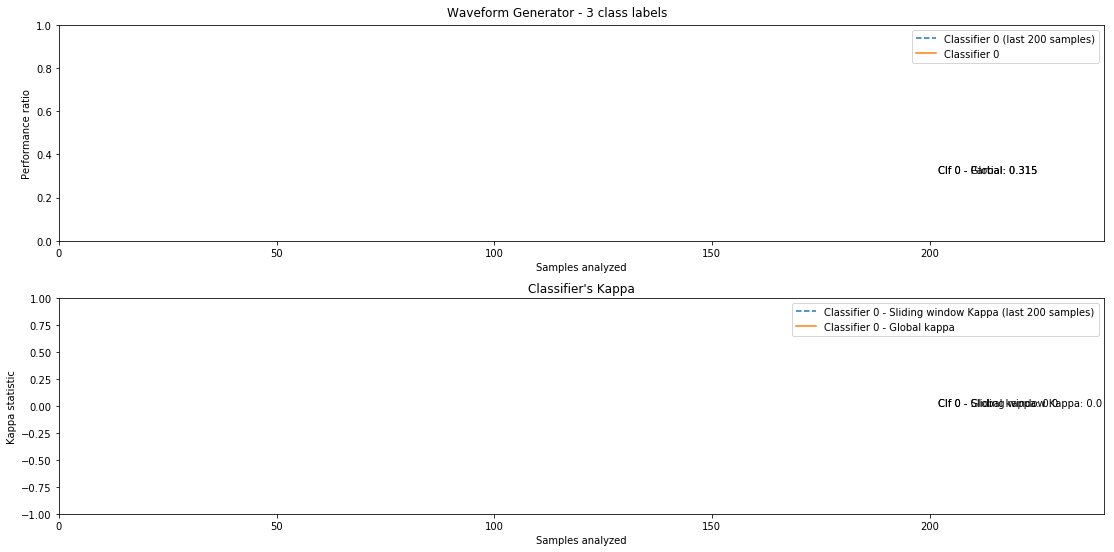

root - INFO - 5.0%


root - INFO - 10.0%


root - INFO - 15.0%


root - INFO - 20.0%


root - INFO - 25.0%


root - INFO - 30.0%


root - INFO - 35.0%


root - INFO - 40.0%


root - INFO - 45.0%


root - INFO - 50.0%


root - INFO - 55.0%


root - INFO - 60.0%


root - INFO - 65.0%


root - INFO - 70.0%


root - INFO - 75.0%


root - INFO - 80.0%


root - INFO - 85.0%


root - INFO - 90.0%


root - INFO - 95.0%


root - INFO - 100.0%
root - INFO - 
Evaluation time: 40.574 s
root - INFO - Total instances: 100000
root - INFO - Classifier 0 - Global accuracy: 0.666
root - INFO - Classifier 0 - Global kappa: 0.499


In [3]:
from skmultiflow.data.generators.waveform_generator import WaveformGenerator
from skmultiflow.classification.trees.hoeffding_tree import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential

# 1. Create a stream
stream = WaveformGenerator()
stream.prepare_for_use()

# 2. Instantiate the classifier
adfht = ADFHoeffdingTree()

# 3. Setup the evaluator
eval = EvaluatePrequential(show_plot=True, pretrain_size=1000, max_instances=100000)

# 4. Run evaluation
eval.eval(stream=stream, classifier=adfht)